In [1]:
import torch 
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
train_dataset = torchvision.datasets.MNIST(
                    root='./data',
                    train=True, 
                    download=True,
                    transform=transforms.ToTensor()
                )

test_dataset = torchvision.datasets.MNIST(
                    root='./data',
                    train=False,
                    download=True,
                    transform=transforms.ToTensor()
                )

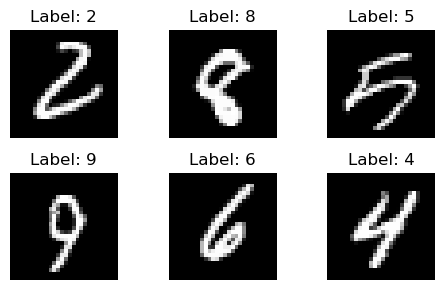

In [3]:
# Define a function to create a grid of images
def create_image_grid(images, labels, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(5, 3))
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(images[i*cols+j].squeeze(), cmap='gray')
            axs[i, j].set_title(f"Label: {labels[i*cols+j]}")
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Select a random subset of images and labels from the dataset
indices = np.random.choice(range(len(train_dataset)), size=6, replace=False)
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

create_image_grid(images, labels, rows=2, cols=3)

In [4]:
# hyper parameters
input_size = 784 # 28x28
hidden_size = 100
n_classes = 10
n_epochs = 2
batch_size = 100
learning_rate = 0.01

In [5]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [6]:
# network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes):
        super(NeuralNet, self).__init__()
        
        self.linear_1 = nn.Linear(input_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, n_classes)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

In [7]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # for cuda
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # for mps
print(f'Using {device} device')

Using mps device


In [8]:
model = NeuralNet(input_size, hidden_size, n_classes).to(device)
print(model)

NeuralNet(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)


In [9]:
# Initialize the loss function
criterion = nn.CrossEntropyLoss()

In [10]:
# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# training loop
n_steps = len(train_loader)
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(images.shape[0], -1).to(device)
        labels = labels.to(device)
    
        # forward pass and loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%100 == 0:
            print(f'epoch {epoch+1}/{n_epochs}, step {i+1}/{n_steps}, loss = {loss.item():.4f}')
        

epoch 1/2, step 100/600, loss = 0.2996
epoch 1/2, step 200/600, loss = 0.1134
epoch 1/2, step 300/600, loss = 0.2002
epoch 1/2, step 400/600, loss = 0.1321
epoch 1/2, step 500/600, loss = 0.1352
epoch 1/2, step 600/600, loss = 0.1491
epoch 2/2, step 100/600, loss = 0.0500
epoch 2/2, step 200/600, loss = 0.2123
epoch 2/2, step 300/600, loss = 0.0680
epoch 2/2, step 400/600, loss = 0.1855
epoch 2/2, step 500/600, loss = 0.2896
epoch 2/2, step 600/600, loss = 0.1594


In [12]:
# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(images.shape[0], -1).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # value, index(cls_label)
        _, predictions = torch.max(outputs, dim=1)
        
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')
        

accuracy = 96.64


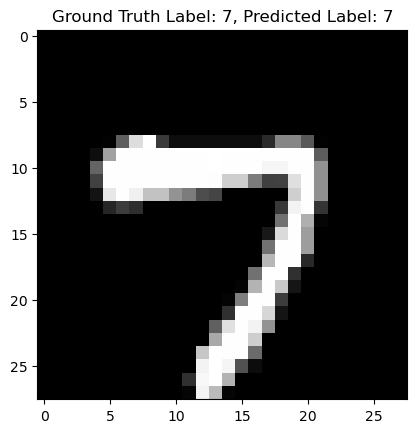

In [13]:
# Get a test image from the dataset
test_image, test_label = next(iter(test_loader))
test_image, test_label = test_image.to(device), test_label.to(device)

# Select a single image from the batch
image_idx = 0
test_image = test_image[image_idx].unsqueeze(0)
test_label = test_label[image_idx].unsqueeze(0)

# Make a prediction
with torch.no_grad():
    model.eval()
    output = model(test_image.view(-1, 784))
    _, predicted = torch.max(output.data, dim=1)

# Plot the image with ground truth and predicted labels
plt.imshow(test_image.cpu().view(28, 28), cmap='gray')
plt.title(f"Ground Truth Label: {test_label.item()}, Predicted Label: {predicted.item()}")
plt.show()